In [19]:
import re 
import itertools
import operator
import copy
import igraph
import heapq
import matplotlib.pyplot as plt
import nltk
# requires nltk 3.2.1
from nltk import pos_tag # nltk.download('maxent_treebank_pos_tagger')
%matplotlib inline

In [2]:
def clean_text_simple(text, my_stopwords, punct, remove_stopwords=True, pos_filtering=True, stemming=True):
    text = text.lower()
    text = ''.join(l for l in text if l not in punct) # remove punctuation (preserving intra-word dashes)
    text = re.sub(' +',' ',text) # strip extra white space
    text = text.strip() # strip leading and trailing white space
    tokens = text.split(' ') # tokenize (split based on whitespace)
    if pos_filtering == True:
        # POS-tag and retain only nouns and adjectives
        tagged_tokens = pos_tag(tokens)
        tokens_keep = []
        for item in tagged_tokens:
            if (
            item[1] == 'NN' or
            item[1] == 'NNS' or
            item[1] == 'NNP' or
            item[1] == 'NNPS' or
            item[1] == 'JJ' or
            item[1] == 'JJS' or
            item[1] == 'JJR'
            ):
                tokens_keep.append(item[0])
        tokens = tokens_keep
    if remove_stopwords:
        tokens = [token for token in tokens if token not in my_stopwords]
    if stemming:
        stemmer = nltk.stem.PorterStemmer()
        tokens_stemmed = list()
        for token in tokens:
            tokens_stemmed.append(stemmer.stem(token))
        tokens = tokens_stemmed
    
    return(tokens)

In [3]:
def terms_to_graph(terms, window_size):
    '''This function returns a directed, weighted igraph from lists of list of terms (the tokens from the pre-processed text)
    e.g., ['quick','brown','fox']
    Edges are weighted based on term co-occurence within a sliding window of fixed size 'w'
    '''
    
    from_to = {}

    w = min(window_size, len(terms))
    # create initial complete graph (first w terms)
    terms_temp = terms[0:w]
    indexes = list(itertools.combinations(range(w), r=2))

    new_edges = []

    for my_tuple in indexes:
        new_edges.append(tuple([terms_temp[i] for i in my_tuple]))
    for new_edge in new_edges:
        if new_edge in from_to:
            from_to[new_edge] += 1
        else:
            from_to[new_edge] = 1

    # then iterate over the remaining terms
    for i in range(w, len(terms)):
        # term to consider
        considered_term = terms[i]
        # all terms within sliding window
        terms_temp = terms[(i - w + 1):(i + 1)]

        # edges to try
        candidate_edges = []
        for p in range(w - 1):
            candidate_edges.append((terms_temp[p], considered_term))

        for try_edge in candidate_edges:

            # if not self-edge
            if try_edge[1] != try_edge[0]:

                # if edge has already been seen, update its weight
                if try_edge in from_to:
                    from_to[try_edge] += 1

                # if edge has never been seen, create it and assign it a unit weight
                else:
                    from_to[try_edge] = 1

    # create empty graph
    g = igraph.Graph(directed=True)

    # add vertices
    g.add_vertices(sorted(set(terms)))

    # add edges, direction is preserved since the graph is directed
    g.add_edges(list(from_to.keys()))

    # set edge and vertice weights
    g.es['weight'] = list(from_to.values()) # based on co-occurence within sliding window
    g.vs['weight'] = g.strength(weights=list(from_to.values())) # weighted degree

    return (g)

In [4]:
def core_dec(g,weighted):
    '''(un)weighted k-core decomposition'''
    # work on clone of g to preserve g 
    gg = copy.deepcopy(g)
    if not weighted:
        gg.vs['weight'] = gg.strength() # overwrite the 'weight' vertex attribute with the unweighted degrees
    # initialize dictionary that will contain the core numbers
    cores_g = dict(zip(gg.vs['name'],[0]*len(gg.vs)))
    
    while len(gg.vs) > 0:
        # find index of lowest degree vertex
        min_degree = min(gg.vs['weight'])
        index_top = gg.vs['weight'].index(min_degree)
        name_top = gg.vs[index_top]['name']
        # get names of its neighbors
        neighbors = gg.vs[gg.neighbors(index_top)]['name']
        # exclude self-edges
        neighbors = [elt for elt in neighbors if elt!=name_top]
        # set core number of lowest degree vertex as its degree
        cores_g[name_top] = min_degree
        ### fill the gap (delete top vertex and its incident edges) ###
        gg.delete_vertices(gg.vs[index_top])
        
        if neighbors:
            if weighted: 
                ### fill the gap (compute the new weighted degrees, save results as 'new_degrees')
                new_degrees = gg.strength(weights=gg.es['weight'])
            else:
                ### fill the gap (same as above but for the basic degree) ###
                new_degrees = gg.strength()
            # iterate over neighbors of top element
            for neigh in neighbors:
                index_n = gg.vs['name'].index(neigh)
                gg.vs[index_n]['weight'] = max(min_degree,new_degrees[index_n])  
        
    return(cores_g)

In [5]:
def accuracy_metrics(candidate, truth):
    # true positives ('hits') are both in candidate and in truth
    tp = len(set(candidate).intersection(truth))
    
    # false positives a.k.a. false alarms are in candidate but not in truth
    fp = len([element for element in candidate if element not in truth])
    
    # false negatives a.k.a. elements in truth but not in candidate 

    fn = len([element for element in truth if element not in candidate])

    ## precision : 
    prec = tp/(tp+fp)
    ## recall : 
    rec = tp/(tp+fn)
    
    if prec+rec != 0:
        f1 = 2*prec*rec/(prec+rec)
    else:
        f1 = 0
    
    return (prec, rec, f1)

# Generate Graph and test the algorithm K-core

In [9]:
import string
from nltk.corpus import stopwords
from igraph import*

In [10]:
stpwds = stopwords.words('english')
punct = string.punctuation.replace('-', '')

my_doc = 'A method for solution of systems of linear algebraic equations \
with m-dimensional lambda matrices. A system of linear algebraic \
equations with m-dimensional lambda matrices is considered. \
The proposed method of searching for the solution of this system \
lies in reducing it to a numerical system of a special kind.'

my_doc = my_doc.replace('\n', '')

In [11]:
# pre-process document
my_tokens = clean_text_simple(my_doc,my_stopwords=stpwds,punct=punct)

g = terms_to_graph(my_tokens, 4)

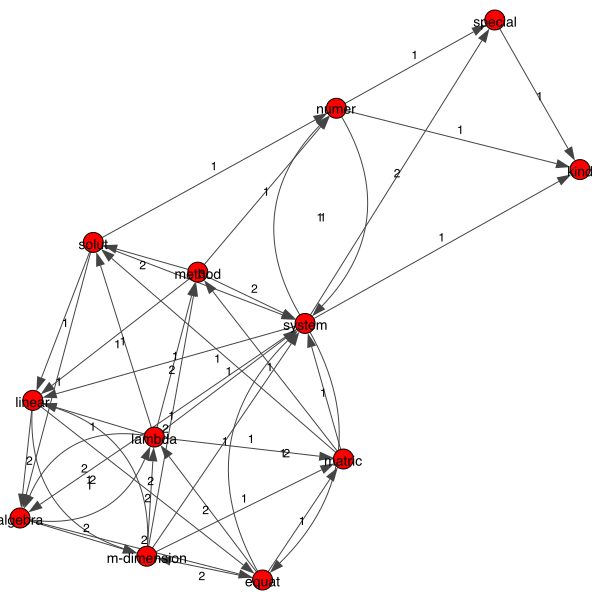

In [15]:
g.es["label"] = g.es["weight"]
g.vs["label"] = g.vs["name"]
plot(g)

In [16]:
edge_weights = []
for edge in g.es:
    source = g.vs[edge.source]['name']
    target = g.vs[edge.target]['name']
    weight = edge['weight']
    edge_weights.append([source, target, weight])

print(edge_weights)

[['method', 'solut', 2], ['method', 'system', 2], ['method', 'linear', 1], ['solut', 'system', 3], ['solut', 'linear', 1], ['system', 'linear', 2], ['solut', 'algebra', 1], ['system', 'algebra', 2], ['linear', 'algebra', 2], ['system', 'equat', 2], ['linear', 'equat', 2], ['algebra', 'equat', 2], ['linear', 'm-dimension', 2], ['algebra', 'm-dimension', 2], ['equat', 'm-dimension', 2], ['algebra', 'lambda', 2], ['equat', 'lambda', 2], ['m-dimension', 'lambda', 2], ['equat', 'system', 1], ['m-dimension', 'system', 1], ['lambda', 'system', 1], ['m-dimension', 'linear', 1], ['lambda', 'linear', 1], ['lambda', 'algebra', 1], ['equat', 'matric', 1], ['m-dimension', 'matric', 1], ['lambda', 'matric', 1], ['m-dimension', 'method', 1], ['lambda', 'method', 1], ['matric', 'method', 1], ['lambda', 'solut', 1], ['matric', 'solut', 1], ['matric', 'system', 1], ['method', 'numer', 1], ['solut', 'numer', 1], ['system', 'numer', 1], ['numer', 'system', 1], ['system', 'special', 2], ['numer', 'special'

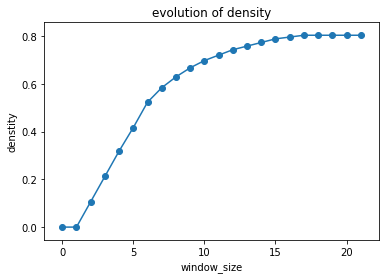

In [20]:
## evaluate the impact of window_size on the density of the graph
density = []
for i in range(len(my_tokens)):
    density.append(terms_to_graph(my_tokens,i).density())
    
plt.plot(density)
plt.xlabel("window_size")
plt.ylabel("denstity")
plt.title("evolution of density")
plt.scatter(range(22),l)

In [22]:
# decompose g
core_numbers = core_dec(g,False)
# retain main core as keywords
max_c_n = max(core_numbers.values())
keywords = [kwd for kwd, c_n in core_numbers.items() if c_n == max_c_n]
print(keywords)


['algebra', 'equat', 'lambda', 'linear', 'm-dimension', 'method', 'solut', 'system']
